In [274]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sys
from imp import reload

from cca import kron_pca
from cca import synth_data

reload(kron_pca)

<module 'cca.kron_pca' from '/Users/davidclark/Projects/ComplexityComponentsAnalysis/cca/kron_pca.py'>

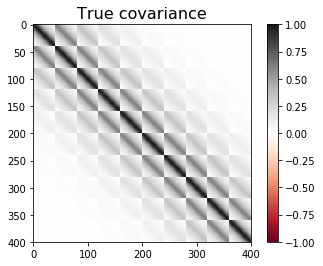

In [360]:
#Make a Kernel and compute true covariance matrix

N = 40
num_lags = 10

K_1 = synth_data.gen_gp_kernel(kernel_type="squared_exp", spatial_scale=10.0, temporal_scale=1.0)
K_2 = synth_data.gen_gp_kernel(kernel_type="exp", spatial_scale=15.0, temporal_scale=2.0)
K_3 = synth_data.gen_gp_kernel(kernel_type="squared_exp", spatial_scale=25.0, temporal_scale=3.0)

def K(t1, t2, x1, x2):
    return (K_1(t1, t2, x1, x2) + K_2(t1, t2, x1, x2) + K_3(t1, t2, x1, x2))/3.

true_cov = synth_data.gen_gp_cov(num_lags, N, K)

plt.imshow(true_cov, vmin=-1, vmax=1, cmap="RdGy")
plt.colorbar()
plt.title("True covariance", fontsize=16)
plt.show()

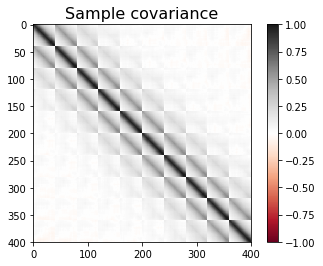

In [361]:
# Generate finite data from the Kernel

num_samples = 400
X = synth_data.sample_gp(kernel=K, T=num_lags, N=N, num_to_concat=num_samples)

#Compute sample covariance matrix

skip = 1
n = int(np.floor((len(X)-num_lags+1)/skip))
X_with_lags = np.zeros((n, N*num_lags))
X_centered = X - X.mean(axis=0)
for i in range(n):
    X_with_lags[i, :] = X_centered[i*skip:i*skip+num_lags].flatten()

sample_cov = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)

plt.imshow(sample_cov, vmin=-1, vmax=1, cmap="RdGy")
plt.colorbar()
plt.title("Sample covariance", fontsize=16)
plt.show()

0.01 1.0
0.01 10.0
0.01 100.0
0.021544346900318832 1.0
0.021544346900318832 10.0
0.021544346900318832 100.0
0.046415888336127774 1.0
0.046415888336127774 10.0
0.046415888336127774 100.0
0.1 1.0
0.1 10.0
0.1 100.0
0.21544346900318834 1.0
0.21544346900318834 10.0
0.21544346900318834 100.0
0.46415888336127775 1.0
0.46415888336127775 10.0
0.46415888336127775 100.0
1.0 1.0
1.0 10.0
1.0 100.0
2.154434690031882 1.0
2.154434690031882 10.0
2.154434690031882 100.0
4.6415888336127775 1.0
4.6415888336127775 10.0
4.6415888336127775 100.0
10.0 1.0
10.0 10.0
10.0 100.0


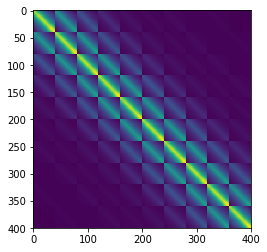

In [373]:
reload(kron_pca)

lambda_L_vals = np.logspace(-2, 1, 10)
lambda_S_vals = np.logspace(0, 2, 3)
ps = N
pt = num_lags

cov_reg, log_likelihood_vals, rank_vals, sparsity_vals = kron_pca.regularize_cov(X_with_lags,
                                                                                ps, pt,
                                                                                lambda_S_vals, lambda_L_vals,
                                                                                num_folds=10,
                                                                                tau=0.5,
                                                                                tol=1e-8,
                                                                                max_iter=1000000,
                                                                                stop_cond_interval=20)

plt.imshow(cov_reg)
plt.show()

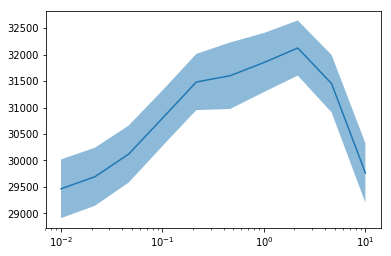

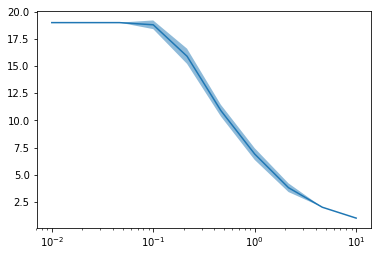

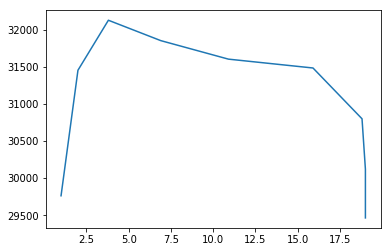

In [374]:
ll_mean = log_likelihood_vals.mean(axis=2)[:, -1]
ll_std = log_likelihood_vals.std(axis=2)[:, -1]

rank_mean = rank_vals.mean(axis=2)[:, 0]
rank_std = rank_vals.std(axis=2)[:, 0]

plt.plot(lambda_L_vals, ll_mean)
plt.fill_between(x=lambda_L_vals, y1=ll_mean-ll_std, y2=ll_mean+ll_std, alpha=0.5)
plt.xscale("log")
plt.show()

plt.plot(lambda_L_vals, rank_mean)
plt.fill_between(x=lambda_L_vals, y1=rank_mean-rank_std, y2=rank_mean+rank_std, alpha=0.5)
plt.xscale("log")
plt.show()

plt.plot(rank_mean, ll_mean)
plt.show()

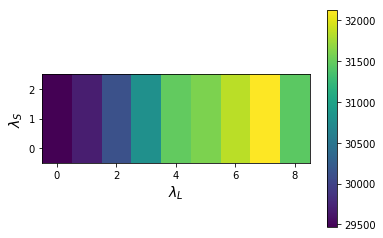

In [376]:
M = log_likelihood_vals.mean(axis=2)

plt.imshow(M.T[:, :-1], origin="lower")
plt.xlabel("$\lambda_L$", fontsize=14)
plt.ylabel("$\lambda_S$", fontsize=14)
plt.colorbar()
plt.show()

In [368]:
log_likelihood_vals.mean(axis=2).max()

32186.748474395332